
# EP1 de Programacao Paralela e Distribuída - MAC5742



| Nome | N° USP |
|------|------|
| Ariel Serranoni Soares da Silva| 7658024 |
| Thiago Martinoni | 9793401 |


## Resumo

Em matemática, fractais são conjuntos auto-similares. Intuitivamente essa propriedade significa que, se $X$ é um conjunto
auto-similar, então $X$ é formado por cópias identicas a si mesmo. Não raramente a representação gráfica desses conjuntos se mostra extremamente interessante, se tornando uma porta de entrada muitos que desejam mergulhar no mundo da matemática.
Em particular, o Conjunto de Mandelbrot é um fractal que pode ser vizualizado facilmente através de um algorítmo utilizando apenas conceitos básicos de programação, como condicionais e laços.

A combinação dos motivos citados acima torna este programa um exercício ideal para disciplinas introdutórias de computação. Neste trabalho vamos fazer mais: implementaremos duas versões deste algorítmo, uma utilizando OpenMPI e outra utilizando CUDA, sendo que nesta houve auxílio de um acelerador (GPU). Além disso, vamos analisar o desempenho de cada programa afim de estudar brevemente o desempenho dessas duas bibliotecas. Os arquivos utilizados para a produção deste estudo encontram-se disponíveis [neste repositório](https://github.com/martinoni/parallel-ep2).

## Implementações em C

Como mencionamos, temos dois programas, cada um responsável por calcular o conjunto de mandelbrot utilizando um método diferente. 
Como o arquivo `mandelbrot_seq.c` serve como base para as paralelizações `mandelbrot_ompi.c` e `mandelbrot_cuda.cu`, é natural 
que comentemos algumas das mudanças que fizemos na implementação do primeiro antes de continuarmos: 

#### Percorrendo vetores multidimensionais com um único laço

Em primeiro lugar, é importante enxergar que a divisão do trabalho de um algorítmo em unidades tão pequenas quanto possível nos oferece uma flexibilidade maior ao alocar tarefas para cada thread, facilitando a paralelização do programa.

Na implementação original que recebemos como base, a função `compute_mandelbrot()` operava com dois laços. Neste contexto,
cada iteração do laço externo era responsável por uma linha da imagem. Portanto, para dividir o trabalho da função em unidades menores do que uma linha, seríamos obrigados a criar threads dentro de threads ou então partir para um novo 
paradigma de implementação do nosso programa. 

No caso da versão implementada em OpenMPI, a mudança que fizemos foi considerar dois parâmetros `i_x_thread` e `i_y_thread`, desta vez percorrendo todos os `image_buffer_size` pixels da imagem. Sabendo o número `image_size` de pixels em cada linha, conseguimos descobrir a linha (`taskid/image_size`) e coluna (`taskid%image_size`) exatas de um pixel a partir de um único parâmetro `taskid` que representa a identificação da thread sendo usada. Uma observação a ser feita é que todos os processos MPI foram abertos na mesma máquina, devido à falta de disponibilidade de outras máquinas com OpenMPI configurado, o que indica que a capacidade real da biblioteca não será testado neste projeto, já que na vida real o número de máquinas que podem ser utilizados na execução do programa é ilimitado. 

No caso da versão CUDA, utilizamos dois parâmetros para a execução do programa: `blockDim` e `gridDim`, que representam as dimensões (x, y) dos blocos (organização das threads dentro dos blocos - determina quantas threads existe em cada bloco) e das grids (organização dos blocos na grid - determina quantos blocos existe na grid), respectivamente. Desta forma, conseguimos determinar as coordenadas (i_x, i_y) dos pixels em que cada thread trabalhará utilizando a lógica `i_x=blockIdx.x*blockDim.x + threadIdx.x` e `i_y=blockIdx.y*blockDim.y + threadIdx.y`.

Tanto em MPI quanto em CUDA, quando um processo ou thread acaba sua primeira tarefa, checa se todos os píxels da imagem já foram incluídos na lista de tarefas, e se não, ganha um novo valor e trabalha em cima do novo píxel. Desta forma, conseguimos abranger todos os píxels da imagem que será gerada.

#### Cálculos de tempo e implicações de latência

Para medir o desempenho de um programa, é essensial que tenhamos uma maneira de medir o tempo de execução do mesmo. 
Para isso, aproveitamos a struct `timer_info` do miniEP3 e encapsulamos as medições feitas na ocasião nas funções `start_timer()` e `stop_timer()`. Também retornamos os resultados utilizando os mesmos métodos no miniEP3 através da função `print_results()`. Vale ressaltar que o tempo medido é feito desde o início do programa, até o fim dele, contando com o tempo de alocação de memória e da escrita do arquivo no disco.

É trivial também que não é somente aumentando o número de threads e processos paralelos executando comandos que diminuímos o tempo de execução do programa. Isso porque existe, no caso do MPI, o tempo de troca de mensagens entre os processos, assim como em cuda existe o tempo de troca de informação da CPU (host) com a GPU (device). Nos dois casos temos o tempo de alocação de memória, seja dentro de cada processo (MPI) ou dentro do device=GPU (CUDA).


## Máquina utilizada

O computador utilizado para a execução dos programas neste projeto foi o `neozil` da Rede Linux do IME, que suporta o CUDA Toolkit 9.1 e está equipado com duas GPUs Nvidia Tesla K20c SM35. As informações foram retiradas do site https://linux.ime.usp.br/wiki/doku.php?id=faq:cuda.

## Infra estrutura Python

Para este relatório, também reaproveitamos muito da estrutura dos trabalhos anteriores. Utilizamos Jupyter notebooks e Python na versão 3.7.3. Também implementamos em Python uma série de funções que foram feitas em Julia anteriormente. A seguinte célula fará as importações necessárias dos pacotes Python:  

In [1]:
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Experimentos e Coleta de Dados 

O Primeiro passo para analisarmos o tempo de execução de um determinado software sempre foi e sempre será executar o programa
em questão. A função abaixo é uma adaptação da função `measure_monte_carlo()` do mini EP3. Seu objetivo é justamente fazer uma chamada de um dos programas em C na linha de comando e salvar os dados que serão relevantes para nossa análise.

A função `mandelbrot()` recebe 6 argumentos: 

O primeiro argumento `method` é uma string que determina qual das implementações
em C deve ser chamada. Os valores possíveis para esta variável são `"cuda"`, e `"mpi"`. 

O segundo argumento `n_mpi` representa o número de processos abertos no programa que utiliza OpenMPI.

O terceiro argumento `x_grid` para a versão em CUDA representa a coordenada x da organização de blocos dentro da grid.

O quarto argumento `y_grid` para a versão em CUDA representa a coordenada y da organização de blocos dentro da grid.

O quinto argumento `x_block` para a versão em CUDA representa a coordenada x da organização de threads dentro de cada bloco.

O sexto argumento `y_block` para a versão em CUDA representa a coordenada y da organização de threads dentro de cada bloco.

Compilando os arquivos em C:

In [2]:
!make

make: Nothing to be done for 'all'.


In [3]:
def mandelbrot(method, n_mpi=None, x_grid=None, y_grid=None, x_block=None, y_block=None):
    if method == "cuda":
        command = '%d %d %d %d' % (x_grid, y_grid, x_block, y_block)
        output = !./mandelbrot_cuda {command}
        output = output[0].split(', ')
    elif method == 'mpi':
        command = '--quiet --host localhost:%d mandelbrot_ompi' % (n_mpi)
        output = !mpirun {command}
        output = output[1].split(', ')
        
    infos = {'method': method, 
             'duration_clock': output[0],
             'duration_mono': output[1],
             'duration_sys': output[2],
             'n_mpi_process':n_mpi, 
             'x_grid_cuda':x_grid, 'y_grid_cuda': y_grid, 
             'x_block_cuda': x_block, 'y_block_cuda':y_block,
            'interaction': None}
    return infos

Para que nossa análise tenha algum valor do ponto de vista estatístico, precisamos nos basear em uma amostra consideravelmente
grande. A função a seguir, também adaptada do miniEP3, tem o intuito de automatizar repetidas chamadas dos programas em C, feitas pela função acima. 

A função `run_experiments()` a seguir nos permite variar todos os parâmetros das chamadas feitas pela função `mandelbrot()` e estabelecer um número de repetições através do através do argumento `repetitions`. Então as chamadas são executadas, os resultados coletados e retornados na forma de um `DataFrame`. A função também recebe outros argumentos que devem estar na forma de lista que vão indicar quais parâmetros serão usados na execução dos programas.


In [4]:
def run_experiments(methods, n_mpis=None, grids=None, blocks=None, repetitions=15):
    !make
    results = []
    for method in methods:
        if method == 'mpi':
            print('Running mandelbrot_mpi:')
            for n_mpi in n_mpis:
                print('n_processes: %d' %  (n_mpi))
                for i in tqdm(range(repetitions)):
                    result = mandelbrot(method, n_mpi)
                    result['interaction'] = i+1
                    results.append(result)
        elif method == 'cuda':
            print('Running mandelbrot_cuda')
            for grid in grids:
                for block in blocks:
                    if grid != (1,1) or block != (1,1):
                        print('Grid_dim: (%d, %d) and Block_dim: (%d, %d)' %  (grid[0], grid[1], block[0], block[1]))
                        for i in tqdm(range(repetitions)):
                            result = mandelbrot(method, 
                                               x_grid=grid[0], y_grid=grid[1],
                                               x_block=block[0], y_block=block[1])
                            result['interaction'] = i+1
                            results.append(result)

    return results
    

Antes de iniciar os experimentos, vamos ajustar parâmetros da função `run_experiments()` conforme a tabela abaixo.
É importante alertar que a execução pode ser demorada (3h+). Por este motivo, optamos por deixar a linha responsável pela execução do experimento comentada.


|               	   | OpenMPI              | CUDA              	                | 
|----------------------|----------------------|-------------------------------------|
| Região               | Triple Spiral Valley | Triple Spiral Valley                |
| Tamanho de Imagem    | 4096                 | 4096                                |
| N° de processos  	   | $1^2\ldots 8^2$      | None              	                |
| Dimensões dos blocos | None 	              | (x, x) para x em $2^0\ldots 2^{5}$ 	|
| Dimensões da grid    | None              	  | (x, x) para x em $2^0\ldots 2^{7}$  |

É importante notar que para a versão em MPI, foi escolhido um espaço de possíveis números de processos utilizados que precisam ser quadrados perfeitos, determinado pelo funcionamento do algoritmo.
Para a versão em CUDA, o que determinará a performance do programa é simplesmente o número de threads ativas, e não a forma com que organizamos elas nos blocos ou na grid. Apesar de estarmos utilizando organizações quadradas de threads dentro dos blocos e de blocos dentro da grid, qualquer combinação (x, y) é possível para os dois casos.

Também ressaltamos que para cada família de arquiteturas da Nvidia existe um número máximo de threads por bloco, que no caso da Tesla é 1024. Por isso optamos por um máximo número de $32\times32$ threads por bloco.


In [5]:
methods = ['mpi', 'cuda']
n_mpis = [x**2 for x in range(1, 9)]
grids = [(2**x, 2**x) for x in range(8)]
blocks = [(2**x, 2**x) for x in range(6)]

# brute = run_experiments(methods, n_mpis, grids, blocks)

In [6]:
# data_bruto = pd.DataFrame(brute)
# data_bruto.to_csv('testes_brutos.csv', index=False)

In [7]:
data = pd.read_csv('testes_brutos.csv')
data

,method,duration_clock,duration_mono,duration_sys,n_mpi_process,x_grid_cuda,y_grid_cuda,x_block_cuda,y_block_cuda,interaction
0,mpi,25.369863,26.240132,26.240129,1.0,NaN,NaN,NaN,NaN,1
1,mpi,25.261793,26.365506,26.365503,1.0,NaN,NaN,NaN,NaN,2
2,mpi,25.449287,25.899301,25.899297,1.0,NaN,NaN,NaN,NaN,3
3,mpi,25.468509,28.011568,28.011564,1.0,NaN,NaN,NaN,NaN,4
4,mpi,25.365352,26.743685,26.743682,1.0,NaN,NaN,NaN,NaN,5
...,...,...,...,...,...,...,...,...,...,...
820,cuda,2.663019,5.104161,5.104159,NaN,128.0,128.0,32.0,32.0,11
821,cuda,3.168981,7.176261,7.176260,NaN,128.0,128.0,32.0,32.0,12
822,cuda,2.396536,5.352022,5.352019,NaN,128.0,128.0,32.0,32.0,13
823,cuda,2.502332,5.044418,5.044417,NaN,128.0,128.0,32.0,32.0,14


# PAREI AQUI
## Próximos passos
- Fazer a tabela com as informações resumidas dos experimentos
- Fazer gráficos separados para MPI e CUDA
- Fazer gráfico comparando melhor caso de MPI VS Melhor caso em CUDA

Com os parâmetros acima, a função `run_experiments()` realiza 825 chamadas na linha de comando, gerando um `DataFrame` com
o mesmo número de linhas. A função a seguir irá nos ajudar fazendo uma primeira filtragem nos dados, computando algumas estatísticas que serão importantes na análise a seguir.

In [8]:
def describe_results(data, repetitions = 15):
    lista_mpi = []
    lista_cuda = []
    for i in tqdm(range(0, data.shape[0], 15)):
        data_aux = data.iloc[i:(i+14)].describe()
        if data.iloc[i].loc['method'] == 'mpi':
            lista_mpi.append({
                'method': data.iloc[i].loc['method'],
                'n_mpi_process': str(data.iloc[i].loc['n_mpi_process']),
                'mean_duration_clock': data_aux.loc['mean'][0],
                'std_duration_clock': data_aux.loc['std'][0],
                'mean_duration_mono': data_aux.loc['mean'][1],
                'std_duration_mono': data_aux.loc['std'][1],
                'mean_duration_sys': data_aux.loc['mean'][2],
                'std_duration_sys': data_aux.loc['std'][2],
                'n_interactions': repetitions
            })
        else:
            lista_cuda.append({
                'method': data.iloc[i].loc['method'],
                'x_grid_cuda': data.iloc[i].loc['x_grid_cuda'],
                'y_grid_cuda': data.iloc[i].loc['y_grid_cuda'],
                'x_block_cuda': data.iloc[i].loc['x_block_cuda'],
                'y_block_cuda': data.iloc[i].loc['y_block_cuda'],
                'mean_duration_clock': data_aux.loc['mean'][0],
                'std_duration_clock': data_aux.loc['std'][0],
                'mean_duration_mono': data_aux.loc['mean'][1],
                'std_duration_mono': data_aux.loc['std'][1],
                'mean_duration_sys': data_aux.loc['mean'][2],
                'std_duration_sys': data_aux.loc['std'][2],
                'n_interactions': repetitions          
            })
            
    return {
        'mpi':lista_mpi,
        'cuda':lista_cuda
    }

Vamos finalmente executar a função acima passando nossos resultados como argumento e salvar em DataFrames separados as informações sobre as execuções em MPI e sobre as em CUDA:

In [9]:
resumo_experimentos = describe_results(data)
resumo_mpi = pd.DataFrame(resumo_experimentos['mpi'])
resumo_cuda = pd.DataFrame(resumo_experimentos['cuda'])

100%|██████████| 55/55 [00:01<00:00, 31.83it/s]


## Vizualização e Análise dos Resultados



### Analisando resultados individualmente

#### Análise MPI
Vamos iniciar nossa discussão sobre os resultados do experimento analisando o impacto do número de processos utilizados para a versão MPI.

É importante destacar que decidimos utilizar a medição feita pela função em C `clock_gettime()` como padrão em toda a análise feita a seguir.

<ErrorbarContainer object of 3 artists>

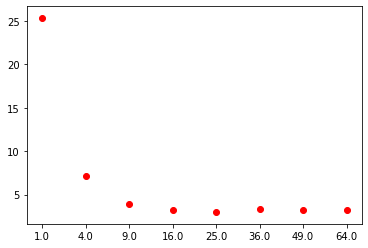

In [10]:
plt.errorbar(resumo_mpi['n_mpi_process'], resumo_mpi['mean_duration_clock'],
             yerr = 2*resumo_mpi['std_duration_clock'], fmt='ro')

Pode-se observar que os tempos de execução diminuem consideravelmente com o aumento do número de processos utilizados. 
Observando o intervalo $[9, 64]$ do número de processos utilizados, podemos checar visualmente os intervalos de confiança estimados para a nossa amostra:

<ErrorbarContainer object of 3 artists>

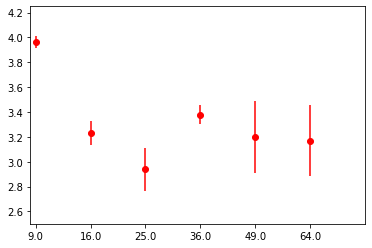

In [12]:
plt.xlim([1.9, 8])
plt.ylim([2.5, 4.25])
plt.errorbar(resumo_mpi['n_mpi_process'], resumo_mpi['mean_duration_clock'],
             yerr = 2*resumo_mpi['std_duration_clock'], fmt='ro')

Como podemos ver no gráfico acima, uma boa escolha de número de processos usados localmente na execução do programa é de $25$. Isso porque a média de tempo de execução é a mais baixa de todos para esse número de processos, além de que, se comparado a outros candidatos com baixo tempo de execução (49 e 64), o intervalo de confiança mostra-se o menor dentre os três, o que é uma vantagem, porque esperamos que futuros experimentos com este número de processos tenha uma maior "consistência" quanto ao tempo de execução. 

- Número de processos escolhido: 25


#### Análise CUDA
Para a versão CUDA, faremos um gráfico tridimensional, onde os eixos representam:
Eixo x: Raíz quadrada do número de threads executadas por bloco.
Eixo y: Raíz quadrada do número de blocos executados por grid.
Eixo z: Tempo de execução

Essas transformações foram feitas para a melhor visualização do gráfico, sem que precisemos escalar os eixos. 

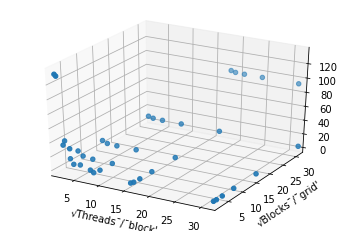

In [18]:
fig = plt.figure()
ax = fig.gca(projection='3d')

x = resumo_cuda['x_block_cuda']
y = resumo_cuda['x_grid_cuda']
z = resumo_cuda['mean_duration_clock']

ax.set_xscale('linear')
ax.set_yscale('linear')

ax.set_xlim(1, 32)
ax.set_ylim(1, 32)

ax.set_xlabel('√Threads¯/¯block\'')
ax.set_ylabel('√Blocks¯/¯grid\'')

# By using zdir='y', the y value of these points is fixed to the zs value 0
# and the (x,y) points are plotted on the x and z axes.

ax.scatter(x, y, zs=z, label='points in (x,z)')

Também plotamos o tempo de execução pela raíz quadrada do número de threads por bloco, agrupados pela raíz quadrada do número de blocos por grid:

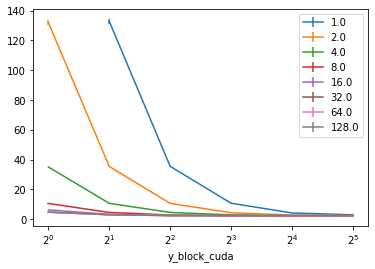

In [17]:
fig, ax = plt.subplots()
ax.set_xscale('log', basex=2)
for key, group in resumo_cuda.groupby('x_grid_cuda'):
    group.plot('y_block_cuda', 'mean_duration_clock', yerr='std_duration_clock', label=key, ax=ax)   # 2

plt.show()

Como podemos ver, os melhores candidatos ao valor de tempo de execução do programa são os experimentos com grids $16\times16$, $32\times32$, $64\times64$ e $128\times128$. Além disso, vamos restringir um número mínimo de $2\times2$ threads por bloco.

Fazendo um gráfico, agora somente com esses experimentos:

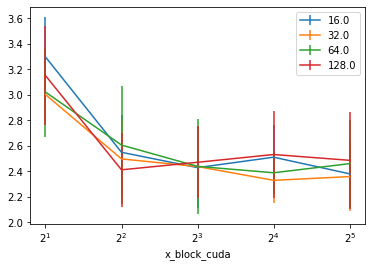

In [28]:
fig, ax = plt.subplots()
ax.set_xscale('log', basex=2)
for key, group in resumo_cuda.loc[23:][resumo_cuda.loc[23:].x_block_cuda > 1].groupby('x_grid_cuda'):
    group.plot('x_block_cuda', 'mean_duration_clock', yerr='std_duration_clock', label=key, ax=ax)   # 2

plt.show()

E novamente um gráfico para $32\times32$ e $64\times64$ blocos por grid:


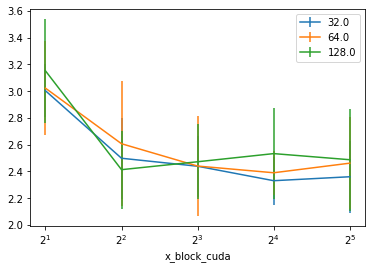

In [33]:
fig, ax = plt.subplots()
ax.set_xscale('log', basex=2)
for key, group in resumo_cuda.loc[29:][resumo_cuda.loc[29:].x_block_cuda > 1].groupby('x_grid_cuda'):
    group.plot('x_block_cuda', 'mean_duration_clock', yerr='std_duration_clock', label=key, ax=ax)   # 2

plt.show()

Separando os plots com os experimentos que possuem uma grid $32\times32$ e $128\times128$

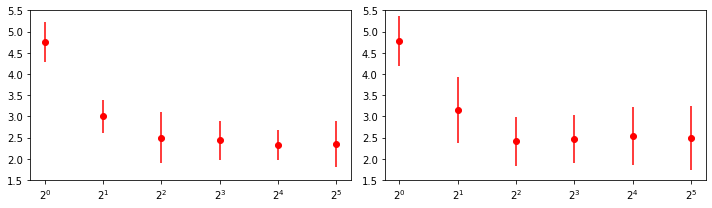

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
ax[0].set_xscale('log', basex=2)
ax[1].set_xscale('log', basex=2)

ax[0].set_ylim(1.5, 5.5)
ax[1].set_ylim(1.5, 5.5)

cuda_1 = resumo_cuda[resumo_cuda.x_grid_cuda == 32]
cuda_2 = resumo_cuda[resumo_cuda.x_grid_cuda == 128]

ax[0].errorbar(cuda_1['x_block_cuda'], cuda_1['mean_duration_clock'],
             yerr = 2*cuda_1['std_duration_clock'], fmt='ro')
ax[1].errorbar(cuda_2['x_block_cuda'], cuda_2['mean_duration_clock'],
             yerr = 2*cuda_2['std_duration_clock'], fmt='ro')


fig.tight_layout()

Podemos ver que há vários candidatos que possuem uma baixa média de tempo de execução, mas existe um destes que possui o menor intervalo de confiança dentre todos.

Desta forma, escolhemos como potencial conjunto de parâmetros para executar os experimentos:
- Dimensão dos blocos:  $(16, 16)$ 
- Dimensão da grid:  $(32, 32)$

### OpenMPI Vs. CUDA

Agora vamos comparar o tempo de execução entre os melhores candidatos da versão em MPI e da versão em CUDA, faznendo comentários a respeito de como um acelerador (GPU) pode impactar na velocidade de execução de um programa, assim como dos potenciais de cada implementação.

Para isso, vamos rodar um número maior do que 15 repetições (200 repetições) para cada um dos dois casos e analisar com gráficos apropriados.

In [ ]:
methods = ['mpi', 'cuda']
n_mpis = [25]
grids = [(32, 32)]
blocks = [(16, 16)]
repetitions = 200

brute_bests = run_experiments(methods, n_mpis, grids, blocks, repetitions)

make: Nothing to be done for 'all'.


  0%|          | 0/200 [00:00<?, ?it/s]

Running mandelbrot_mpi:
n_processes: 25


 25%|██▌       | 50/200 [04:47<13:26,  5.38s/it]

In [ ]:
brute_bests = pd.DataFrame(brute_bests)
brute_bests.to_csv('testes_brutos_melhores.csv', index=False)

<ErrorbarContainer object of 3 artists>

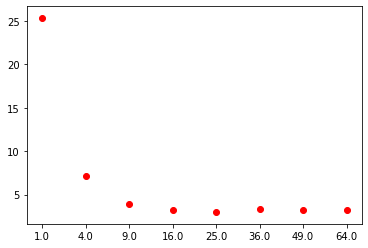

In [63]:
plt.errorbar(melhor_mpi['method'], resumo_mpi['mean_duration_clock'],
             yerr = 2*resumo_mpi['std_duration_clock'], fmt='ro')

Os gráficos acima dão a entender que, independentemente da região fixada, tanto o tamanho da imagem quanto o número de threads
influenciam no tempo de execução: fixado um valor para `threads`, vemos  que o tempo médio de duração aumenta conforme aumentamos o valor de `size`. Em contrapartida, fixado uma valor para `size` o tempo de execução parece diminuir conforme aumentamos o número de `threads`.

A seguir, vamos verificar se nossa primeira impressãp se confirma. Para tal, estudaremos as seções dos gráficos acima. Primeiro, vamos fixar um valor `s` para a variável `size` e verificar o comportamento dos experimentos em cada região conforme variamos o valor de `threads`.

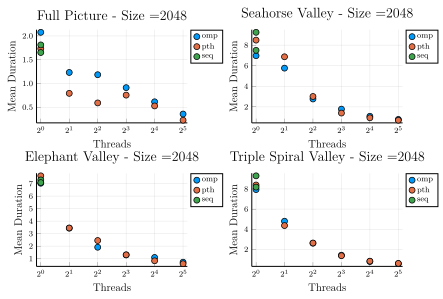

In [112]:
s=2048
data_fps=data_full_picture[data_full_picture.size.==s,:]
data_evs=data_elephant_valley[data_elephant_valley.size.==s,:]
data_shvs=data_seahorse_valley[data_seahorse_valley.size.==s,:]
data_tsvs=data_triple_spiral[data_triple_spiral.size.==s,:]

p_full_fs=scatter(data_fps.threads,
                            data_fps.mean_duration_mono,
                            xlabel="Threads",
                            ylabel="Mean Duration",
                            title = "Full Picture - Size =$s",
                            xaxis=:log2,
                            group=data_fps.method)

p_sh_fs=scatter(data_shvs.threads,
                data_shvs.mean_duration_mono,
                xlabel="Threads",
                ylabel = "Mean Duration",
                title = "Seahorse Valley - Size =$s",
                xaxis=:log2,
                group=data_shvs.method)

p_ev_fs=scatter(data_evs.threads,
                data_evs.mean_duration_mono,
                xlabel="Threads",
                ylabel = "Mean Duration",
                title = "Elephant Valley - Size =$s",
                xaxis=:log2,
                group=data_evs.method)
p_ts_fs=scatter(data_tsvs.threads,
                data_tsvs.mean_duration_mono,
                xlabel="Threads",
                ylabel = "Mean Duration",
                title = "Triple Spiral Valley - Size =$s",
                xaxis=:log2,
                group=data_tsvs.method)
plot(p_full_fs,p_sh_fs,p_ev_fs,p_ts_fs,layout=(2,2))

Com os resultados acima em mãos, podemos ver que, para valores "grandes" (por exemplo $2^{12}$) de `s`, nossa primeira visão das paralelizações concorda com os dados que temos. Isso se deve ao fato de que, com um mesmo total trabalho a ser executado, dividir tarefas entre um número maior de "trabalhadores" tende a diminuir o tempo total que será preciso. Entretanto, quando `s` assume valores "pequenos"(por exemplo $2^4$), o tempo de execução cresce conforme aumentamos do número de threads. Isto occore pois, com pouco trabalho a ser feito, o prejuízo causado pela necessidade de criar threads e alocar tarefas não é compensado pelo ganho em se dividir o trabalho.



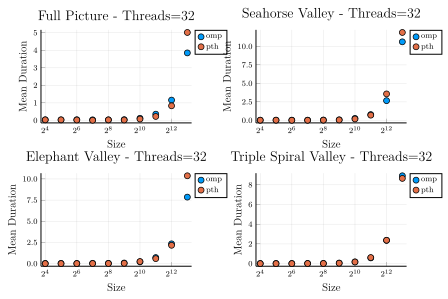

In [116]:
t=32
data_fpt=data_full_picture[data_full_picture.threads.==t,:]
data_evt=data_elephant_valley[data_elephant_valley.threads.==t,:]
data_sht=data_seahorse_valley[data_seahorse_valley.threads.==t,:]
data_tst=data_triple_spiral[data_triple_spiral.threads .==t,:]

p_full_fixed_thread =scatter(data_fpt.size,
                            data_fpt.mean_duration_mono,
                            xlabel="Size",
                            ylabel="Mean Duration",
                            title="Full Picture - Threads=$t",
                            xaxis=:log2,
                            group=data_fpt.method)

p_seahorse_fixed_thread =scatter(data_sht.size,
                            data_sht.mean_duration_mono,
                            xlabel="Size",
                            ylabel="Mean Duration",
                            title="Seahorse Valley - Threads=$t",
                            xaxis=:log2,
                            group=data_sht.method)

p_elephant_fixed_thread =scatter(data_evt.size,
                            data_evt.mean_duration_mono,
                            xlabel="Size",
                            ylabel="Mean Duration",
                            title="Elephant Valley - Threads=$t",
                            xaxis=:log2,
                            group=data_evt.method)

p_spiral_fixed_thread =scatter(data_tst.size,
                            data_tst.mean_duration_mono,
                            xlabel="Size",
                            ylabel="Mean Duration",
                            title="Triple Spiral Valley - Threads=$t",
                            xaxis=:log2,
                            group=data_tst.method)

plot(p_full_fixed_thread,p_seahorse_fixed_thread,p_elephant_fixed_thread,p_spiral_fixed_thread,layout=(2,2))

Mais uma vez, as vizualizações acima confirmam nossa primeira visão sobre o desempenho das paralelizações. Fixado um valor qualquer para a variável `threads`, o tempo médio de execução de ambas as paralelizações aumenta conforme aumentamos o valor de `size`. Isto se deve ao fato de que o aumento da variável size implica em um aumento do total de trabalho que será realizado por cada thread, retardando a execução da mesma. Aumentando o tempo de execução de cada thread, claramente iremos aumentar o tempo total para a execução de um programa. 

### Diferenças entre as regiões

Durante toda a análise acima notamos que, por mais que o comportamento geral dos experimentos fosse o mesmo, temos diferenças,
principalmente de escala, entre as regiões. Pensamos em dois fatores que poderiam hipotéticamente ser responsáveis por tal disparidade.

A primeira hipótese que levantamos é que a causa esteja relacionada à precisão necessária para o cálculo das iterações
em cada região. Isto é, quando dividimos regiões com área pequena em pixels, temos uma "malha mais fina". Nessa situação, o computador provavelmente faz cálculos envolvendo uma precisão maior (mais casas depois da vírgula), retardando o tempo de execução. 

A segunda possibilidade que cogitamos é que algumas regiões do plano incluem pontos cuja norma é maior. Este fato que pode fazer com que o cálculo da cor dos pixels correspondentes aconteca mais rápido. O motivo para isso é que, quanto maior
a norma do ponto correspondente a um píxel $p$, menor é o valor de $k\in\mathbb{N}$ para que $\|f_p^k(0)\|>4$ (onde $f_p(z)=z^2+p$ para quiasquer $p,z\in\mathbb{C}$). Nesse contexto, menos cálculos são precisos para determinar a cor 
correspondente ao pixel $p$.

A seguir, vamos rapidamente verificar se nossos dados contrariam alguma das nossas hipóteses. Primeiro vamos calcular a área de
cada região e a média dos tempos de execução (misturando as três implementações em C). No caso em que as regiões de menor área
tenham menor tempo médio de execução descartamos nossa primeira hipótese.

In [125]:
area_full = seq_full.delta_x[1]*seq_full.delta_y[1]
area_seahorse=seq_seahorse.delta_x[1]*seq_seahorse.delta_y[1]
area_elephant=seq_elephant.delta_x[1]*seq_elephant.delta_y[1]
area_spiral=seq_spiral.delta_x[1]*seq_spiral.delta_y[1]

areas=["Full Picture"=>[area_full,mean(parsed_results[parsed_results.region.=="Full Picture",:].mean_duration_mono)]
        "Seahorse Valley" =>[area_seahorse,mean(parsed_results[parsed_results.region.=="Seahorse Valley",:].mean_duration_mono)]
        "Elephant Valley" =>[area_elephant,mean(parsed_results[parsed_results.region.=="Elephant Valley",:].mean_duration_mono)]
        "Triple Spiral Valley" =>[area_spiral,mean(parsed_results[parsed_results.region.=="Triple Spiral Valley",:].mean_duration_mono)]]


4-element Array{Pair{String,Array{Float64,1}},1}:
         "Full Picture" => [16.0, 1.9946317292857145]               
      "Seahorse Valley" => [0.010000000000000009, 9.652045365714287]
      "Elephant Valley" => [0.039999999999999994, 7.15308674357143] 
 "Triple Spiral Valley" => [0.03519999999999998, 7.704362805714285] 

A partir dos cálculos efetuados acima, vemos que os dados não negam a primeira possibilidade. De fato, vemos que quanto maior
a área de uma região menor será o tempo de execução, como previmos.

Para fazer algum tipo de verificação para nossa segunda hipótese, temos de obter algum parâmetro que indique a norma dos pontos em uma determinada região. Com efeito, para cada região $R$ vamos considerar o parâmetro $p_R$ como o máximo entre as normas dos vértices de $R$. Este número indica que a região $R$ está toda contida na bola centrada em 0 com raio $p_R$.  

In [132]:
norms=DataFrame(region=String[],
                p_r=Float64[],
                mean_duration=Float64[])
for tuple in regions
    max=0
        for i1 in 1:length(tuple[2])
            for i2 in 1:length(tuple[2])
                if i1 != i2
                    norm = tuple[2][i1]^2+tuple[2][i2]^2
                    if norm > max
                            max=norm
                    end
                end
            end
        end
    append!(norms,DataFrame(region=tuple[1],p_r=max,mean_duration=mean(parsed_results[parsed_results.region.==tuple[1],:].mean_duration_mono)))
end
norms

,region,p_r,mean_duration
,String,Float64,Float64
1,Full Picture,10.25,1.99463
2,Seahorse Valley,1.13,9.65205
3,Elephant Valley,0.17125,7.15309
4,Triple Spiral Valley,0.875432,7.70436


In [131]:
cor(norms.norm,norms.mean_duration)

-0.9179483360671918

Os resultados obtidos acima não confirmam nossa segunda hipótese de forma tão óbvia quanto os anteriores confirmam a primeira. Entretanto, calculando o coeficiente de correlação entre as colunas `p_r` e `mean_duration` do Data Frame `norms`, vemos que as variáveis em questão estão altamente relacionadas de maneira inversamente proporcional, como imaginamos. Mais uma vez, não negamos nossa hipótese.

## Observações finais

### Infra Estrutura de trabalho remoto utilizando SSH

A realização deste trabalho demandou muito poder computacional. Como nenhum dos elementos da dupla possui uma máquina adequada para realizar os experimentos pedidos, precisamos aprender um pouco sobre o uso remoto da rede IME. Como
nesse momento em que a grande maioria da comunidade IME não consegue estar fisicamente presente no instituto, resolvemos fazer
uma pequena descrição de como utilizamos a máquina brucutu IV da rede IME para realizar nossos experimentos.

Em primeiro lugar, gostaríamos de agradecer à comunidade, que 
mantém [esta página](https://wiki.ime.usp.br/) com diversas informações úteis, inclusive 
sobre o acesso remoto às redes do IME. Mais especificamente, 
[esta página](https://wiki.ime.usp.br/servicos:processamento) contém uma lista das máquinas do IME com grande poder computacional e orientações de como utilizá-las.

#### Incluindo um novo kernel

Como usuários da rede, não temos as permissões necessárias para instalar, desinstalar, 
nem atualizar os programas disponíveis nas máquinas.
Por exemplo, a versão do Kernel Julia que está disponível na rede IME é a 1.0.3 e não é possível atualizar. Porém, ainda assim
foi possível instalar a versão 1.3.0 do Kernel através do repositório da Linguagem Julia no Github. Ao instalar o pacote `IJulia` nesta nova versão, temos ambas as versões disponíveis no jupyter. É importante lembrarmos que a instalação foi feita na pasta  `/var/tmp/` uma vez que não há espaço suficiente na cota individual de armazenamento. Em suma, por mais que não seja possível utilizar o gerenciador de pacotes `apt`, é possível instalar programas temporariamente através de métodos mais diretos como download de binários ou clonagem de repositórios no GitHub.

#### Abrindo uma porta para acesso local

Mesmo com a interface gráfica de um navegador de internet, ainda temos que lidar com algum tipo de delay, o que torna um tanto desconfortável editar um documento como este. Para resolver este problema, utilizamos o comando

``` ssh -NL [port]:localhost:[port] [seulogin]@brucutuiv.ime.usp.br```

para que possamos acessar o servidor oferecido pelo Jupyter localmente!

# OMPI + CUDA
- Fazer um processo usar uma placa de vídeo (com cudaSetId) e outro processo usar a outra placa de vídeo.